<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/ComputerVision/Lecture%2006%20-%20Image%20Descriptors/Lecture_06_Image_Descriptors-PCA-EDGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lecture 06 - Image Descriptors
  
  * Descriptors 
    * Projections
    * Edges Descriptors

  * High Dimensional Data Visualization
    * PCA

  * Classification - KNN

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
#Keras to import datasets, not for deep learning (yet)
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [42]:
#Auxiliary Function to plot side by side
def plot_sidebyside(img_list,titles,colormap=None,figsize=(12,6)):
  n = len(img_list)
  figure, axis = plt.subplots(1, n, figsize=figsize)

  for i in range(n):
    axis[i].imshow(img_list[i], cmap=colormap)
    axis[i].set_title(titles[i])
    axis[i].axis('off')
  # Combine all the operations and display
  plt.show()

#The MNIST and Fashion MNIST Benchmarks Dataset
 * Handwritten Isolated Digits
 * Clothes

In [43]:
#Uncomment for mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_lbls = ['0','1','2','3','4','5','6','7','8','9']

#Uncomment for fashion mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
mnist_lbls = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print(x_train.shape,x_test.shape)

(60000, 28, 28) (10000, 28, 28)


##Plot Samples

T-shirt/top


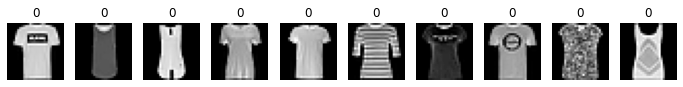

Trouser


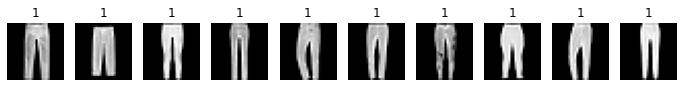

Pullover


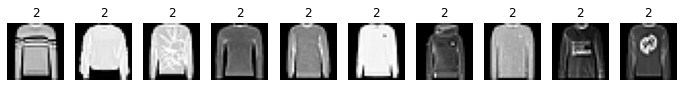

Dress


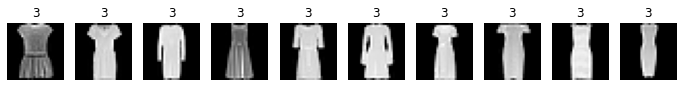

Coat


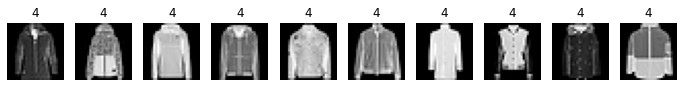

Sandal


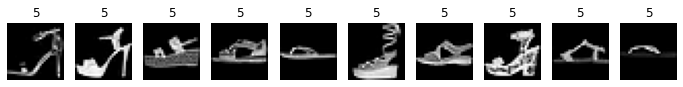

Shirt


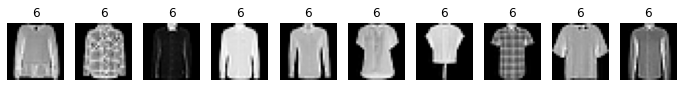

Sneaker


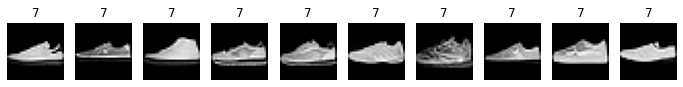

Bag


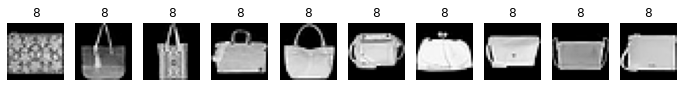

Ankle boot


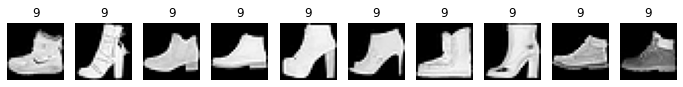

In [44]:
N_CLASSES = 10
N_SAMPLES = 10
for i in range(N_CLASSES):
  idxs = np.where(y_train == i)[0]
  idxs = idxs[:N_SAMPLES]
  
  print(mnist_lbls[i])
  plot_sidebyside(x_train[idxs],y_train[idxs],'gray')

#Descriptors



##Computing Histogram Projections (Vertical and Horizontal)

In [45]:
def extract_projection(data,axis=0):
  features = []
  for d in data:
    height, width = d.shape

    if axis < 2:
      proj = np.sum(d, axis=axis)
      proj = proj/255
    else:
      proj0 = np.sum(d, axis=0)
      proj1 = np.sum(d, axis=1)       
      proj = np.concatenate([proj0,proj1],axis = 0)/255
  
    features.append(proj)
    

  return np.array(features)

train_feat_v = extract_projection(x_train,axis=0)
test_feat_v = extract_projection(x_test,axis=0)

train_feat_h = extract_projection(x_train,axis=1)
test_feat_h = extract_projection(x_test,axis=1)

train_feat_hv = extract_projection(x_train,axis=2)
test_feat_hv = extract_projection(x_test,axis=2)

  

##Plotting Histogram Projections

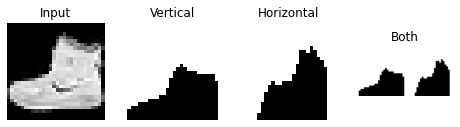

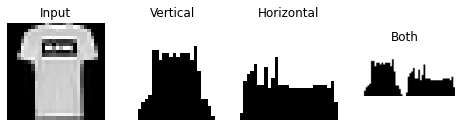

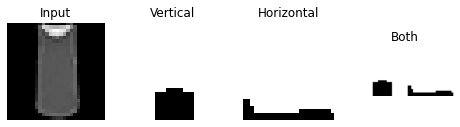

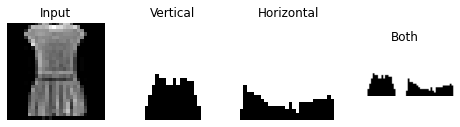

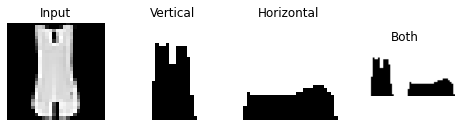

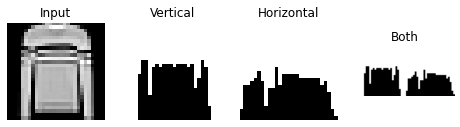

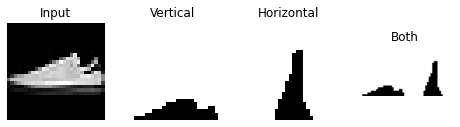

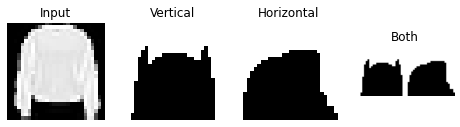

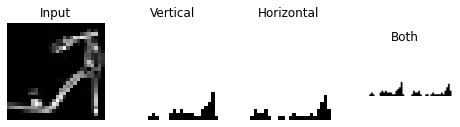

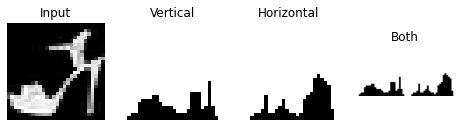

In [46]:
 for vert,horiz,both,img in zip(train_feat_v[:10],train_feat_h[:10],train_feat_hv[:10],x_train[:10]): 
  
  # create a black image with zeros 
  vert_proj = np.zeros((28,28),dtype=np.uint8)
  horiz_proj = np.zeros((28,28),dtype=np.uint8)
  both_proj = np.zeros((28,56),dtype=np.uint8)
  
  height = 28
  
  # Make the vertical projection histogram
  for idx, value in enumerate(vert):
      cv2.line(vert_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)

  for idx, value in enumerate(horiz):
      cv2.line(horiz_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)
  
  for idx, value in enumerate(both):      
      cv2.line(both_proj, (idx, 0), (idx, height-int(value)), (255,255,255), 1)

  
  plot_sidebyside([img,vert_proj,horiz_proj,both_proj],['Input','Vertical','Horizontal','Both'],'gray',(8,8))

##Extracting and Plotting Edges 


###Laplace
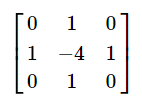

###Sobel
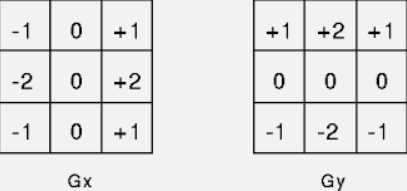

### Canny
  * Gaussian Gradient Based Filter (John F. Canny 1986)
  
  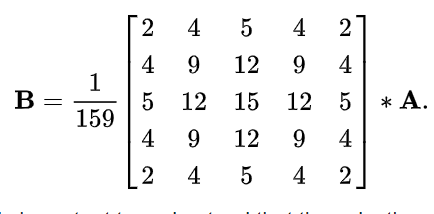

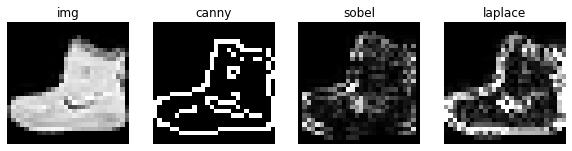

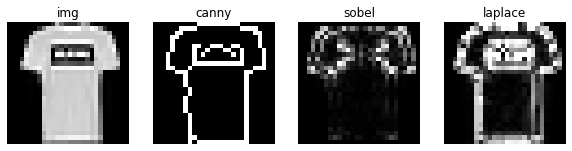

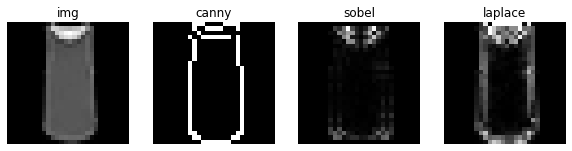

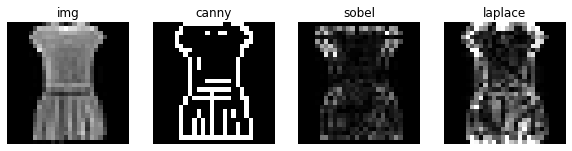

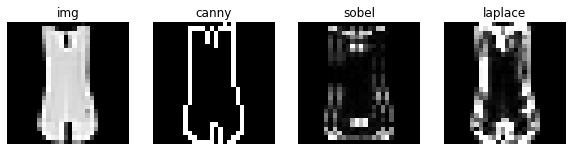

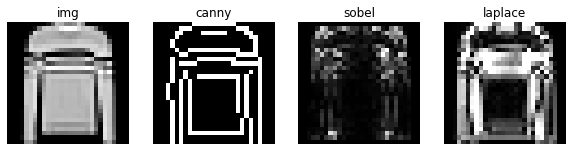

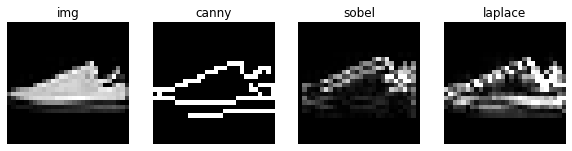

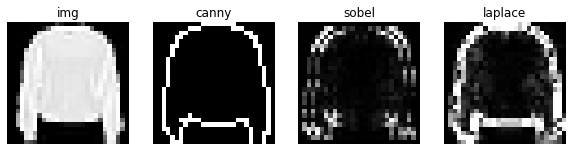

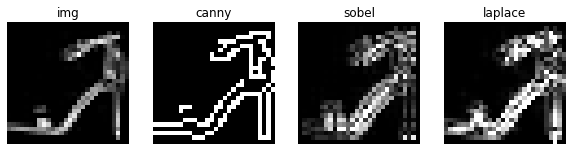

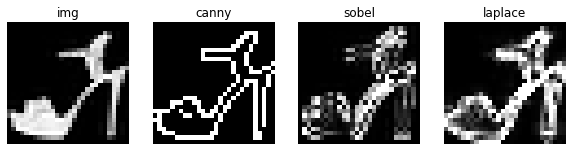

In [47]:
def extract_edges(data,algorithm='canny'):
  features = []

  
  for img in data:
    #Evaluate smooth on fashion mnist data
    #img = cv2.GaussianBlur(img,(5,5),0)
    #_,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

    if algorithm=='canny':
      edges = cv2.Canny(img,100,200)      
    
    elif algorithm=='sobel':
                                      #V H 
      edges = cv2.Sobel(img,cv2.CV_64F,1,1)
      #Back to UINT8
      edges = cv2.convertScaleAbs(edges) 

    elif algorithm=='laplace':
      edges = cv2.Laplacian(img,cv2.CV_64F)
      #Back to UINT8
      edges = cv2.convertScaleAbs(edges)                     
    
    features.append(edges)

  return np.array(features)

train_feat_canny = extract_edges(x_train,'canny')
test_feat_canny = extract_edges(x_test,'canny')

train_feat_sobel = extract_edges(x_train,'sobel')
test_feat_sobel = extract_edges(x_test,'sobel')

train_feat_laplace = extract_edges(x_train,'laplace')
test_feat_laplace = extract_edges(x_test,'laplace')

for canny,sobel,laplace,img in zip(train_feat_canny[:10],train_feat_sobel[:10],train_feat_laplace[:10],x_train[:10]): 
  plot_sidebyside([img,canny,sobel,laplace],['img','canny','sobel','laplace'],'gray',figsize=(10,6))

#Data Reduction and Visualization

Lets use the PCA and t-SNE to better understand the features and visualize them

## PCA

In [48]:
def pca_FitAndPlot(data,labels,title='PCA Plot',figsize=(10,6)):
  pca_features = PCA(n_components=2).fit_transform(data)  

  plt.figure(figsize=figsize)
  x, y = zip(*pca_features)
  plt.scatter(x, y)

  for i in range(len(x)):  
    plt.text(x=x[i], y=y[i], s=labels[i])
  
  plt.title(title)
  plt.show()

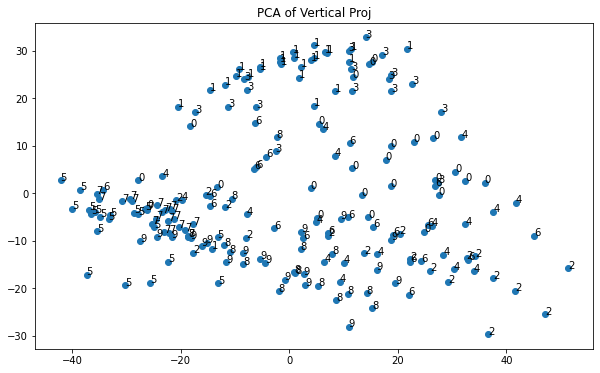

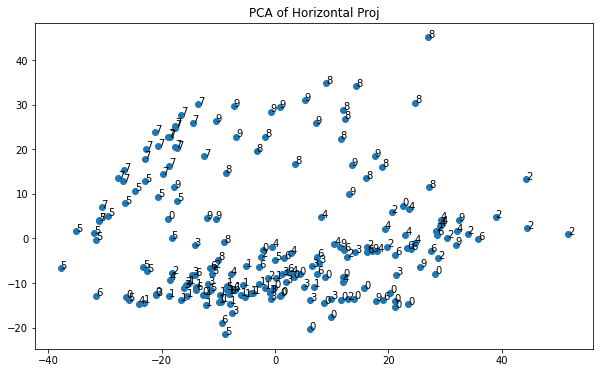

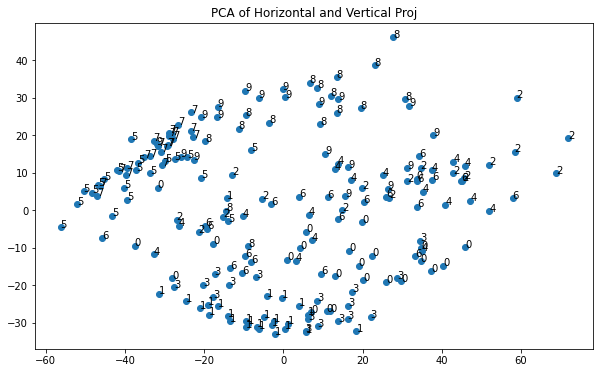

In [49]:
amount = 200
data = train_feat_v[:amount]
pca_FitAndPlot(data,y_train,'PCA of Vertical Proj')

data = train_feat_h[:amount]
pca_FitAndPlot(data,y_train,'PCA of Horizontal Proj')

data = train_feat_hv[:amount]
pca_FitAndPlot(data,y_train,'PCA of Horizontal and Vertical Proj')

PCA Components Explanation

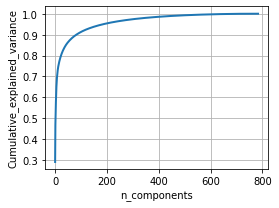

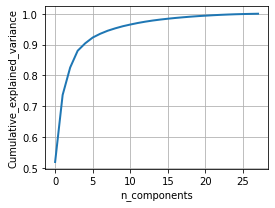

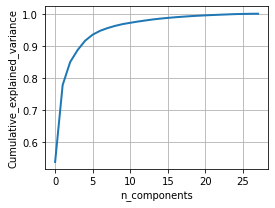

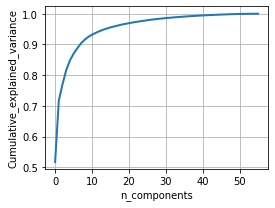

In [50]:
for data in [x_train,train_feat_h,train_feat_v,train_feat_hv]:
  
  #flatten
  data = data.reshape(data.shape[0],-1)

  pca = PCA(n_components=data.shape[1])
  reduced_data = pca.fit_transform(data)
  percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cum_var_explained = np.cumsum(percentage_var_explained)
                                
  plt.figure(figsize=(4, 3))  
  plt.clf()
  plt.plot(cum_var_explained, linewidth=2)
  plt.axis('tight')
  plt.grid()
  plt.xlabel('n_components')
  plt.ylabel('Cumulative_explained_variance')
  plt.show()

Lets try PCA with edges features...

(60000, 28, 28)
(60000, 784)


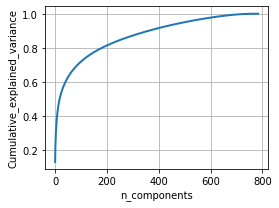

In [51]:
print(train_feat_laplace.shape)
pca_features = np.reshape(train_feat_laplace,(60000,28*28))
print(pca_features.shape)

pca = PCA(n_components=pca_features.shape[1])
reduced_data = pca.fit_transform(pca_features)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)
                              
plt.figure(figsize=(4, 3))  
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

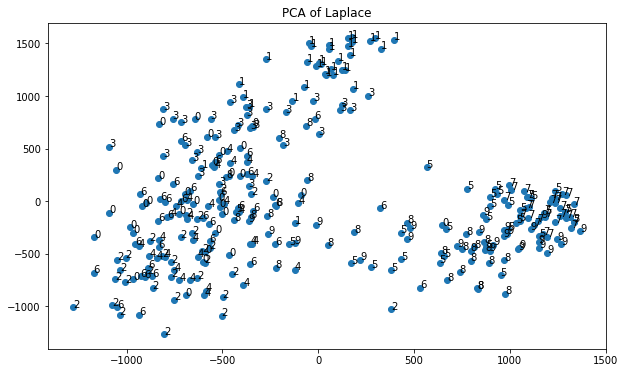

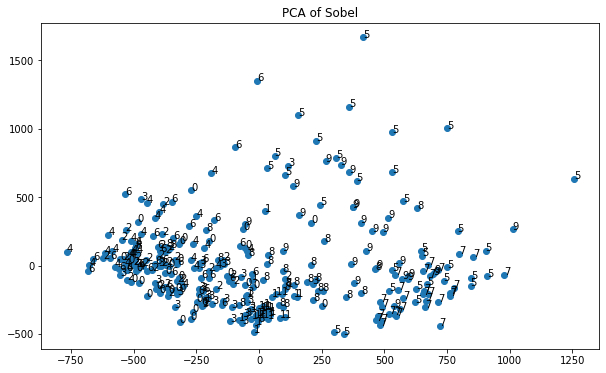

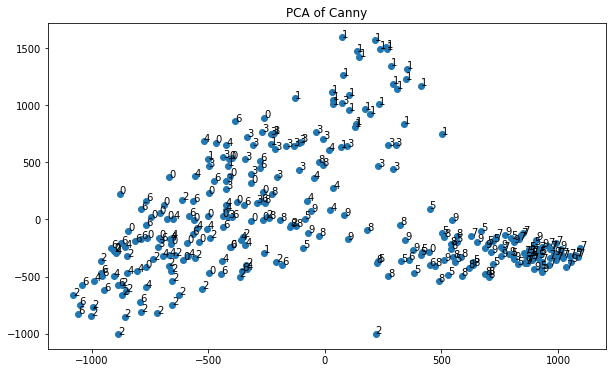

In [52]:
data = np.reshape(train_feat_laplace[:300],(300,28*28))
pca_FitAndPlot(data,y_train,'PCA of Laplace')

data = np.reshape(train_feat_sobel[:300],(300,-1))
pca_FitAndPlot(data,y_train,'PCA of Sobel')

data = np.reshape(train_feat_canny[:300],(300,-1))
pca_FitAndPlot(data,y_train,'PCA of Canny')


#Performance Evaluation

Let's train a KNN classifier to evaluate all those features.

To facilitate, the function below evaluates and plots model metrics

In [53]:
def performance_evaluation(y_test, predictions,info_message):
  
  print(f"Evaluation of ", info_message)
  print(f"{metrics.classification_report(y_test, predicted)}\n")
  print(mnist_lbls)
  disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)
  disp.figure_.suptitle("Confusion Matrix")
  plt.show()

  id = np.random.randint(300)
  idx1,idx2=id,id+10  
  diff = y_test - predictions  
  idxs = np.where(diff == 0)
  
  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=(20, 10))
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()      
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f"Lbl: {lbl} Pred: {prediction}")
  
      
  idxs = np.where(diff != 0)
  _, axes = plt.subplots(nrows=1, ncols=(idx2-idx1), figsize=(20, 10))
  for ax, image, lbl, prediction, in zip(axes, x_test[idxs],y_test[idxs], predictions[idxs]):
      ax.set_axis_off()      
      ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      ax.set_title(f"Lbl: {lbl} Pred: {prediction}")

  plt.show()

#K-Neareast Neighboors Model (KNN)

  The KNN model computes the euclidian distance of vectors in feature space.

  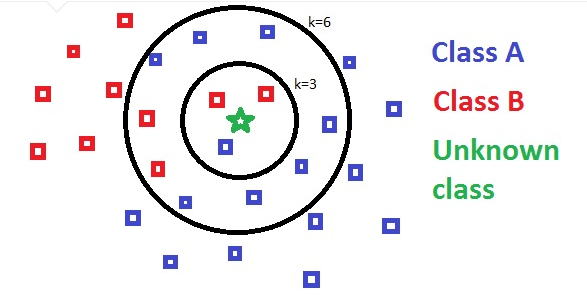

    

Let's evaluate KNN for features extract from histogram projections.




Processing  Horizontal Proj
(60000, 28) (10000, 28)
Evaluation of  Horizontal Proj
              precision    recall  f1-score   support

           0       0.71      0.64      0.68      1000
           1       0.85      0.94      0.89      1000
           2       0.60      0.57      0.59      1000
           3       0.61      0.64      0.62      1000
           4       0.61      0.63      0.62      1000
           5       0.85      0.74      0.80      1000
           6       0.47      0.48      0.47      1000
           7       0.83      0.86      0.85      1000
           8       0.92      0.83      0.87      1000
           9       0.79      0.88      0.83      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


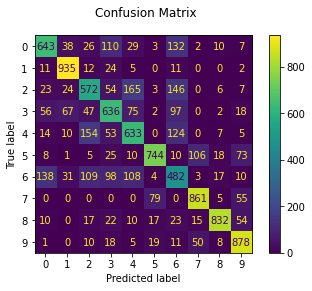

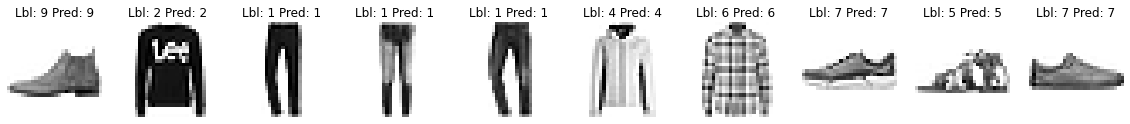

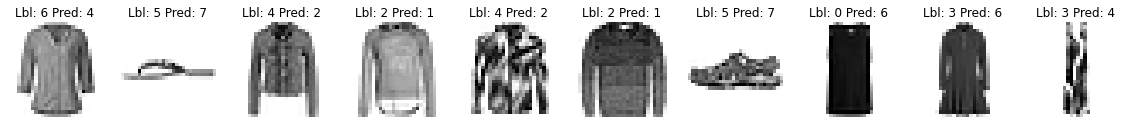

Processing  Vertical Proj
(60000, 28) (10000, 28)
Evaluation of  Vertical Proj
              precision    recall  f1-score   support

           0       0.66      0.71      0.68      1000
           1       0.97      0.94      0.95      1000
           2       0.60      0.61      0.61      1000
           3       0.77      0.73      0.75      1000
           4       0.57      0.56      0.56      1000
           5       0.93      0.83      0.88      1000
           6       0.44      0.42      0.43      1000
           7       0.82      0.90      0.86      1000
           8       0.84      0.84      0.84      1000
           9       0.88      0.91      0.90      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


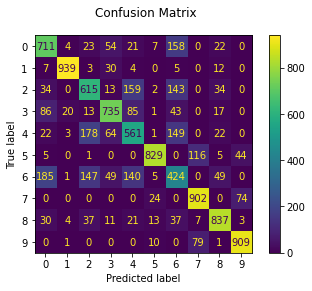

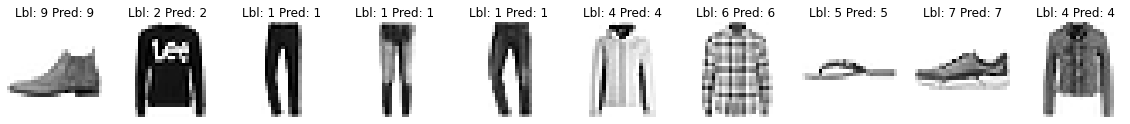

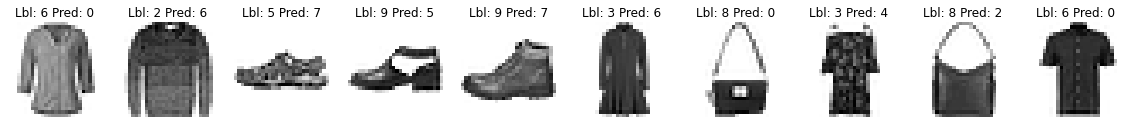

Processing  Both
(60000, 56) (10000, 56)
Evaluation of  Both
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1000
           1       0.97      0.96      0.96      1000
           2       0.68      0.67      0.68      1000
           3       0.83      0.79      0.81      1000
           4       0.65      0.68      0.66      1000
           5       0.95      0.84      0.89      1000
           6       0.50      0.54      0.52      1000
           7       0.85      0.91      0.88      1000
           8       0.95      0.91      0.93      1000
           9       0.87      0.93      0.90      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.80     10000
weighted avg       0.80      0.79      0.80     10000


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


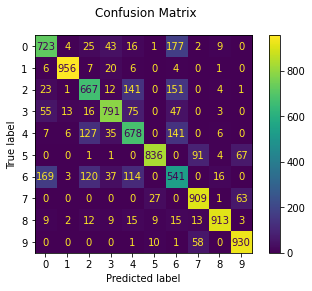

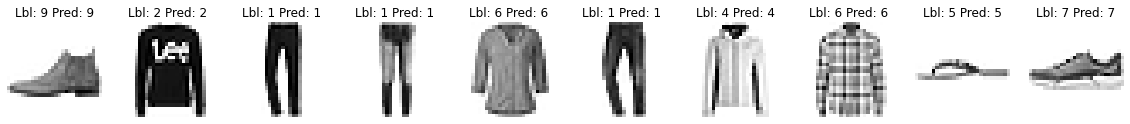

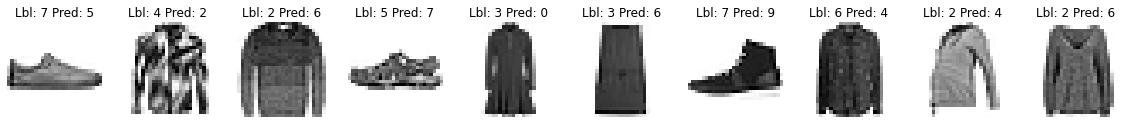

In [54]:
K = 1
train_data = [train_feat_h,train_feat_v,train_feat_hv]
test_data = [test_feat_h,test_feat_v,test_feat_hv]
data_info = ['Horizontal Proj', 'Vertical Proj', 'Both']
for train,test,info in zip(train_data,test_data,data_info):
  print('Processing ', info )
  knn = KNeighborsClassifier(n_neighbors=K)
  
  #flatten
  train = train.reshape(train.shape[0],-1)
  test = test.reshape(test.shape[0],-1)

  print(train.shape, test.shape)
  knn.fit(train, y_train)
  predicted = knn.predict(test)
  performance_evaluation(y_test,predicted,info)

Let evaluate KNN for features extract from edges

Processing  Canny
(60000, 784) (10000, 784)
Evaluation of  Canny
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1000
           1       0.94      0.95      0.94      1000
           2       0.68      0.72      0.70      1000
           3       0.84      0.82      0.83      1000
           4       0.69      0.68      0.69      1000
           5       0.97      0.80      0.88      1000
           6       0.57      0.52      0.54      1000
           7       0.85      0.92      0.88      1000
           8       0.97      0.86      0.91      1000
           9       0.85      0.95      0.90      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


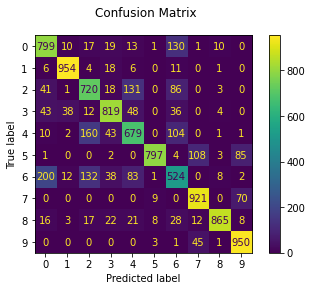

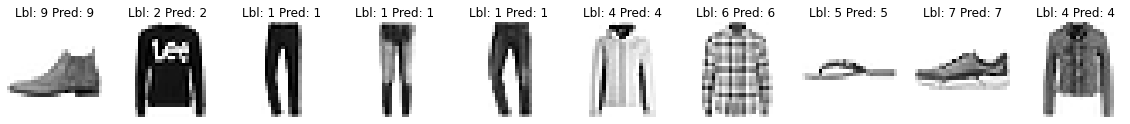

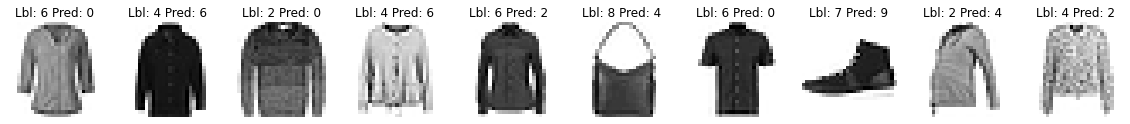

Processing  Sobel
(60000, 784) (10000, 784)
Evaluation of  Sobel
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1000
           1       0.91      0.96      0.93      1000
           2       0.66      0.78      0.72      1000
           3       0.84      0.81      0.82      1000
           4       0.76      0.70      0.73      1000
           5       0.98      0.81      0.89      1000
           6       0.60      0.58      0.59      1000
           7       0.84      0.94      0.89      1000
           8       0.96      0.92      0.94      1000
           9       0.91      0.96      0.93      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


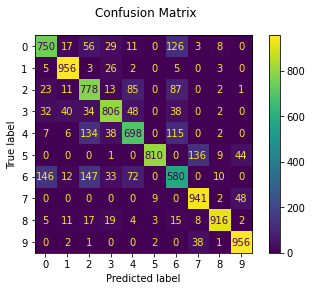

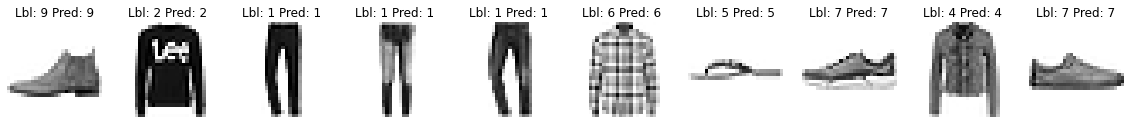

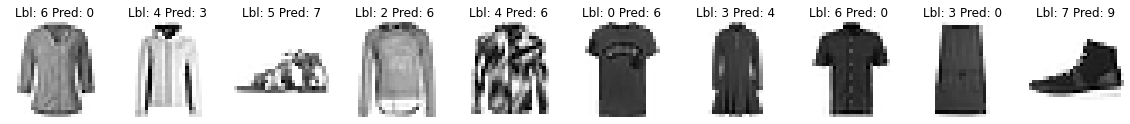

Processing  Laplace
(60000, 784) (10000, 784)
Evaluation of  Laplace
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       0.93      0.97      0.95      1000
           2       0.69      0.78      0.73      1000
           3       0.87      0.83      0.85      1000
           4       0.75      0.72      0.73      1000
           5       0.99      0.84      0.91      1000
           6       0.62      0.58      0.60      1000
           7       0.86      0.95      0.90      1000
           8       0.98      0.94      0.96      1000
           9       0.91      0.97      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


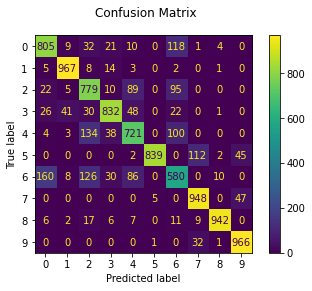

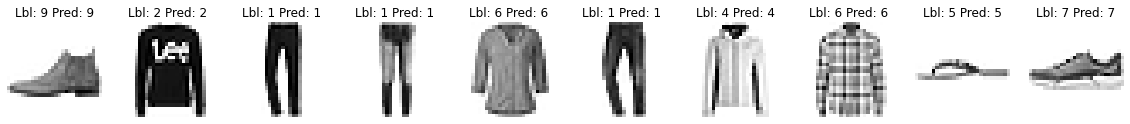

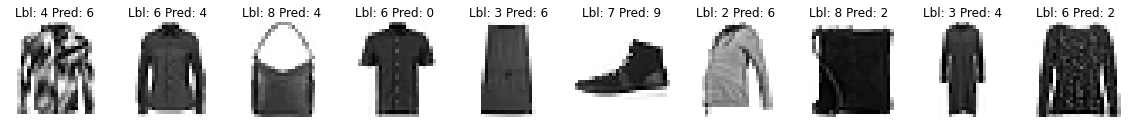

In [55]:
K=1
train_data = [train_feat_canny,train_feat_sobel,train_feat_laplace]
test_data = [test_feat_canny,test_feat_sobel,test_feat_laplace]
data_info = ['Canny','Sobel','Laplace']
for train,test,info in zip(train_data,test_data,data_info):
  print('Processing ', info)
  knn = KNeighborsClassifier(n_neighbors=K)  

  #flatten
  train = train.reshape(train.shape[0],-1)
  test = test.reshape(test.shape[0],-1)

  print(train.shape, test.shape)
  knn.fit(train, y_train)
  predicted = knn.predict(test)
  performance_evaluation(y_test,predicted,info)

#Practice 01
  

  * Try different parameters for K neighbors for KNN model. 

  * Try to reduce features based on PCA Variance Explanation. 

  * Explain the impact on performance
  

#Practice 02

* Lets try the fashion mnist dataset


#Practice 03
  * Research and Implement other features:
    * lbp
    * lbq
    * Gabor filters
    * Hog filters
    * Zernik and Hu Moments
    * Freeman code
    * PCA
    * Or......design your own feature extractor

    